In [44]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [74]:
def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [75]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_2/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_2/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float32)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[0][1]#/3.1415926
            Y = torch.tensor( Y, dtype=torch.float32 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y

In [76]:
all_ids = [str(i) for i in  list(np.arange(0,1000,1))]
train_ids = all_ids[:800]
val_ids   = all_ids[800:]
params = {
    'batch_size'  : 32,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

In [77]:
for batch in training_generator:
    break
batch[1].shape

torch.Size([32, 1])

tensor([0.0343])

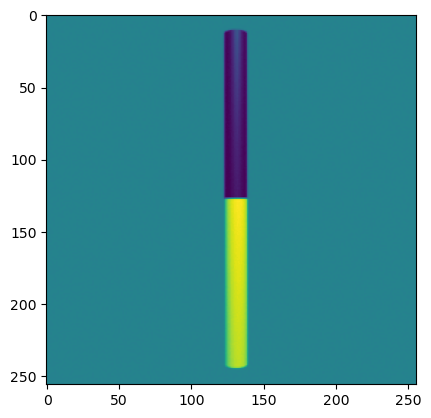

In [125]:
plt.imshow(batch[0][0][0])
batch[1][0]

tensor([0.6721])

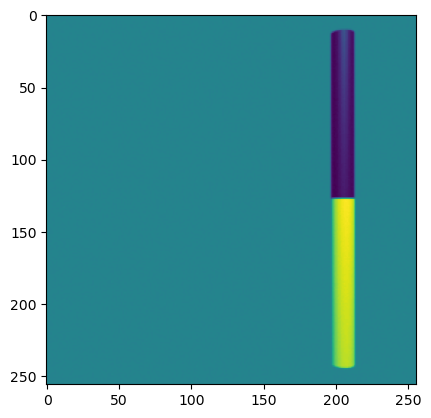

In [127]:
plt.imshow(batch[0][2][0])
batch[1][2]

In [145]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [152]:
model = Network()
no_of_params(model)

380111

In [39]:
class simple_cnn(nn.Module):
    def __init__(self):
        super(simple_cnn, self).__init__()
        self.conv1 = nn.Conv2d(1,4,kernel_size=4,padding=2,stride=2)
        self.conv2 = nn.Conv2d(4,8,kernel_size=4,padding=2,stride=2)
        self.conv3 = nn.Conv2d(8,16,kernel_size=4,padding=2,stride=2)
        self.conv4 = nn.Conv2d(16,32,kernel_size=4,padding=2,stride=2)
        #maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.activation = nn.Tanh()

        self.fc_1  = nn.Linear(9248,2048)
        self.fc_2  = nn.Linear(2048,1)
    
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = self.conv4(x)
        x = self.activation(x)
        x = torch.flatten(x,1)
        x = self.fc_1(x)
        x = self.activation(x)
        x = self.fc_2(x)
        x = self.activation(x)
        
        return x
model = simple_cnn()
no_of_params(model)

18954877

In [ ]:
from vit_pytorch import ViT
model = ViT(
        image_size  = 256,#256,
        channels    = 1,#1,
        patch_size  = 16,
        num_classes = 1,
        dim         = 32,
        depth       = 2,
        heads       = 4,
        mlp_dim     = 64,
        dropout     = 0.1,
        emb_dropout = 0.1,
    )
no_of_params(model)

In [153]:
lr = 1e-7
wd = 1e-4
epochs = 20
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd
    )

gamma = 0.9
scheduler_step_size = 1
scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size = scheduler_step_size, 
    gamma     = gamma)

# scheduler = lr_scheduler.ExponentialLR(
#     optimizer, 
#     #step_size = scheduler_step_size, 
#     gamma     = gamma)

#scheduler.optimizer.param_groups[0]['lr']

In [154]:
train_losses = []
val_losses   = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", train_loss, " Val loss: ",val_loss)

EPOCH:  1  Train loss:  0.24851249277591705  Val loss:  0.2453199646302632
EPOCH:  2  Train loss:  0.21347206354141235  Val loss:  0.23473504185676575
EPOCH:  3  Train loss:  0.1524035570025444  Val loss:  0.15267492298569
EPOCH:  4  Train loss:  0.14590988904237748  Val loss:  0.12097324005195073
EPOCH:  5  Train loss:  0.08133764669299126  Val loss:  0.07441692426800728
EPOCH:  6  Train loss:  0.08336668670177459  Val loss:  0.10025438666343689
EPOCH:  7  Train loss:  0.096417755484581  Val loss:  0.07778136325734002
EPOCH:  8  Train loss:  0.054554435014724734  Val loss:  0.036692937569958825
EPOCH:  9  Train loss:  0.03572919771075249  Val loss:  0.0530962518283299
EPOCH:  10  Train loss:  0.059165996611118314  Val loss:  0.09115316452724594
EPOCH:  11  Train loss:  0.07764072015881539  Val loss:  0.08150605644498553
EPOCH:  12  Train loss:  0.06734531760215759  Val loss:  0.0652429743536881
EPOCH:  13  Train loss:  0.042793176993727686  Val loss:  0.038058883643576076
EPOCH:  14  

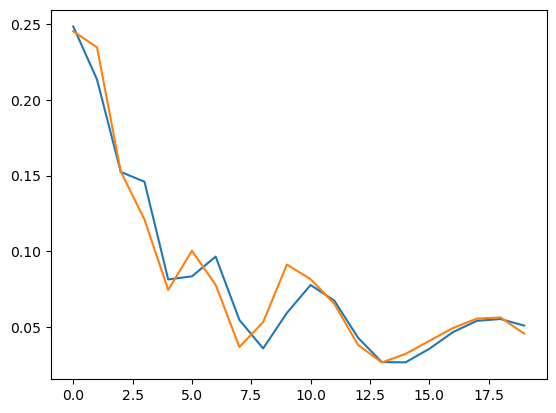

In [155]:
plt.plot(train_losses)
plt.plot(val_losses)

In [156]:
for batch in validation_generator:
    break
output = model(batch[0])
output

tensor([[-0.4341],
        [-0.4634],
        [ 0.2445],
        [-0.3206],
        [ 0.7842],
        [ 0.4701],
        [-0.1670],
        [-0.4253],
        [-0.4368],
        [-0.3732],
        [ 0.4430],
        [ 0.8790],
        [ 0.7846],
        [-0.4343],
        [ 0.6038],
        [ 0.1230],
        [-0.2708],
        [-0.2978],
        [ 0.7422],
        [-0.4340],
        [ 0.6116],
        [ 0.0137],
        [ 0.4640],
        [-0.5688],
        [ 0.5772],
        [-0.5676],
        [ 0.2645],
        [-0.4949],
        [-0.4419],
        [-0.4307],
        [ 0.3297],
        [ 0.8102]], grad_fn=<TanhBackward0>)

In [157]:
batch[1]

tensor([[-0.5555],
        [-0.6873],
        [ 0.0470],
        [-0.4733],
        [ 0.9715],
        [ 0.1735],
        [-0.2102],
        [-0.5179],
        [-0.6319],
        [-0.2879],
        [ 0.1718],
        [ 0.7261],
        [ 0.9534],
        [-0.4172],
        [ 0.3036],
        [-0.0662],
        [-0.4704],
        [-0.2805],
        [ 0.2934],
        [-0.4172],
        [ 0.2348],
        [ 0.0343],
        [ 0.1746],
        [-0.9769],
        [ 0.3152],
        [-0.9760],
        [ 0.0619],
        [-0.4848],
        [-0.5939],
        [-0.6022],
        [ 0.1100],
        [ 0.5366]])

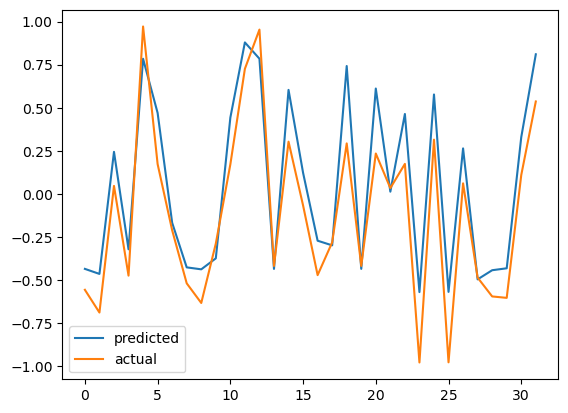

In [159]:
plt.plot(output.detach().numpy(),label="predicted")
plt.plot(batch[1].detach().numpy(),label="actual")
plt.legend()

(tensor([-0.4340], grad_fn=<SelectBackward0>), tensor([-0.4172]))

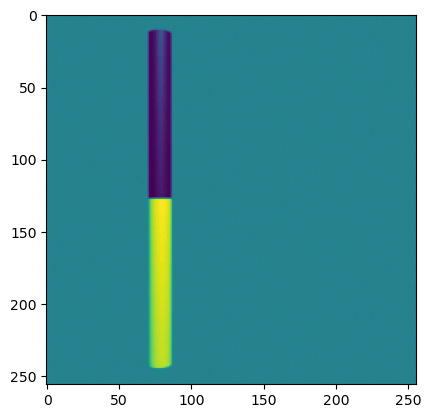

In [170]:
i = 19
plt.imshow( batch[0][i][0] ) 
model(batch[0])[i], batch[1][i]

In [104]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(3)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*122*122, 1)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output)))     
        output = output.view(-1, 24*122*122)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output

In [106]:
model = Network()

In [107]:
model(batch[0])

tensor([[-0.0769],
        [-0.3395],
        [-0.1337],
        [-0.2621],
        [-0.1860],
        [-0.3517],
        [ 0.1420],
        [ 0.1395],
        [-0.3233],
        [-0.1567],
        [-0.0434],
        [ 0.0372],
        [-0.0105],
        [-0.0468],
        [-0.2757],
        [-0.1481],
        [-0.1247],
        [-0.5078],
        [-0.0054],
        [ 0.1468],
        [ 0.1083],
        [-0.4653],
        [-0.4806],
        [-0.5038],
        [-0.1135],
        [-0.1031],
        [-0.0951],
        [ 0.2366],
        [ 0.0165],
        [ 0.2053],
        [-0.2012],
        [-0.0967]], grad_fn=<TanhBackward0>)

In [91]:
no_of_params(model)

380111

Network(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=357216, out_features=1, bias=True)
)